In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 1. Loading Libraries

In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import Counter
from itertools import cycle                   
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
tqdm.pandas()

from autocorrect import Speller
from textblob import TextBlob
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional, GlobalMaxPooling1D

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, RocCurveDisplay

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. Load Data

In [3]:
data = pd.read_csv('../Dataset/ireland-news-headlines.csv', engine='python', encoding='utf-8')
data = data.drop(columns=['publish_date'])
data.drop_duplicates(inplace=True) 
data['headline_text'] = data['headline_text'].astype(str) 
data

,headline_category,headline_text
0,news,UUP sees possibility of voting Major out
1,news,Pubs targeted as curbs on smoking are extended
2,news,Papers reveal secret links with O'Neill cabinet
3,news,Domestic chaos as Italy takes EU presidency
4,news,Learning about the star to which we owe life
...,...,...
1611490,news.politics.oireachtas,Reserve members of Defence Forces to be allowe...
1611491,culture,Maureen Dowd: Joe Biden is 'crazy about the Ir...
1611492,sport.others,Andy Murray rolls back the years to own Centre...
1611493,news.health,Delta variant could do 'significant damage' in...


# 3. Initial Analysis

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1524579 entries, 0 to 1611494
Data columns (total 2 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   headline_category  1524579 non-null  object
 1   headline_text      1524579 non-null  object
dtypes: object(2)
memory usage: 34.9+ MB


In [4]:
set([category for category in data.headline_category if "." not in category] ) 

{'business', 'culture', 'lifestyle', 'news', 'opinion', 'sport'}

In [5]:
data = data[(data['headline_category'] == 'business') | 
            # (data['headline_category'] == 'culture') | 
            # (data['headline_category'] == 'lifestyle')| 
            (data['headline_category'] == 'news')| 
            # (data['headline_category'] == 'opinion')| 
            (data['headline_category'] == 'sport')]

In [9]:
# data['root_category'] = data['headline_category'].apply(lambda x: x.split(".")[0]) 
# data

,headline_category,headline_text,root_category
0,news,UUP sees possibility of voting Major out,news
1,news,Pubs targeted as curbs on smoking are extended,news
2,news,Papers reveal secret links with O'Neill cabinet,news
3,news,Domestic chaos as Italy takes EU presidency,news
4,news,Learning about the star to which we owe life,news
...,...,...,...
1611490,news.politics.oireachtas,Reserve members of Defence Forces to be allowe...,news
1611491,culture,Maureen Dowd: Joe Biden is 'crazy about the Ir...,culture
1611492,sport.others,Andy Murray rolls back the years to own Centre...,sport
1611493,news.health,Delta variant could do 'significant damage' in...,news


In [6]:
data['headline_category'].value_counts()

news        566594
sport       152274
business    106364
Name: headline_category, dtype: int64

In [10]:
# value_counts_df = data['headline_category'].value_counts().reset_index()
# value_counts_df.columns = ['name', 'count']
# value_counts_df.to_csv("headline_category_counts.csv")
# value_counts_df

,name,count
0,news,580242
1,sport,158683
2,business,111435
3,opinion.letters,79276
4,opinion,49946
...,...,...
98,lifestyle.food.restaurant,203
99,news.technology,191
100,business.markets.bonds,127
101,lifestyle.abroad.working-abroad,116


In [9]:
# shortlisted_genres = data["Genre"].value_counts().reset_index(name="count").query("count >2000")["index"].tolist()
# shortlisted_genres

['drama', 'comedy']

In [11]:
# data = data[data['Genre'].isin(shortlisted_genres)].reset_index(drop=True)
# data

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...
1,1907,How Brown Saw the Baseball Game,American,Unknown,Unknown,comedy,https://en.wikipedia.org/wiki/How_Brown_Saw_th...,Before heading out to a baseball game at a nea...
2,1907,Laughing Gas,American,Edwin Stanton Porter,"Bertha Regustus, Edward Boulden",comedy,https://en.wikipedia.org/wiki/Laughing_Gas_(fi...,The plot is that of a black woman going to the...
3,1908,The Adventures of Dollie,American,D. W. Griffith,"Arthur V. Johnson, Linda Arvidson",drama,https://en.wikipedia.org/wiki/The_Adventures_o...,On a beautiful summer day a father and mother ...
4,1908,The Black Viper,American,D. W. Griffith,D. W. Griffith,drama,https://en.wikipedia.org/wiki/The_Black_Viper,A thug accosts a girl as she leaves her workpl...
...,...,...,...,...,...,...,...,...
8648,2017,Peechankai,Tamil,Ashok,"R. S. Karthik, Anjali Rao, Vivek Prasanna, M. ...",comedy,https://en.wikipedia.org/wiki/Peechankai,Smoodhu is a famous left handed pickpocket and...
8649,2017,Kootathil Oruthan,Tamil,T. J. Gnanavel,"Ashok Selvan, Priya Anand, Samuthirakani",drama,https://en.wikipedia.org/wiki/Kootathil_Oruthan,"Arvind, an ordinary Joe who is not noticed by ..."
8650,2017,Podhuvaga En Manasu Thangam,Tamil,Thalapathy Prabhu,"Udhayanidhi Stalin, Nivetha Pethuraj, Parthiep...",comedy,https://en.wikipedia.org/wiki/Podhuvaga_En_Man...,Two nearby villages in the southern suburbs of...
8651,2017,Magalir Mattum,Tamil,Bramma,"Jyothika, Saranya, Urvashi, Bhanupriya",drama,https://en.wikipedia.org/wiki/Magalir_Mattum_(...,Prabhavathi (Jyothika) is a feisty independent...


Text(0.5, 1.0, 'Rating Distribution Across Dataset')

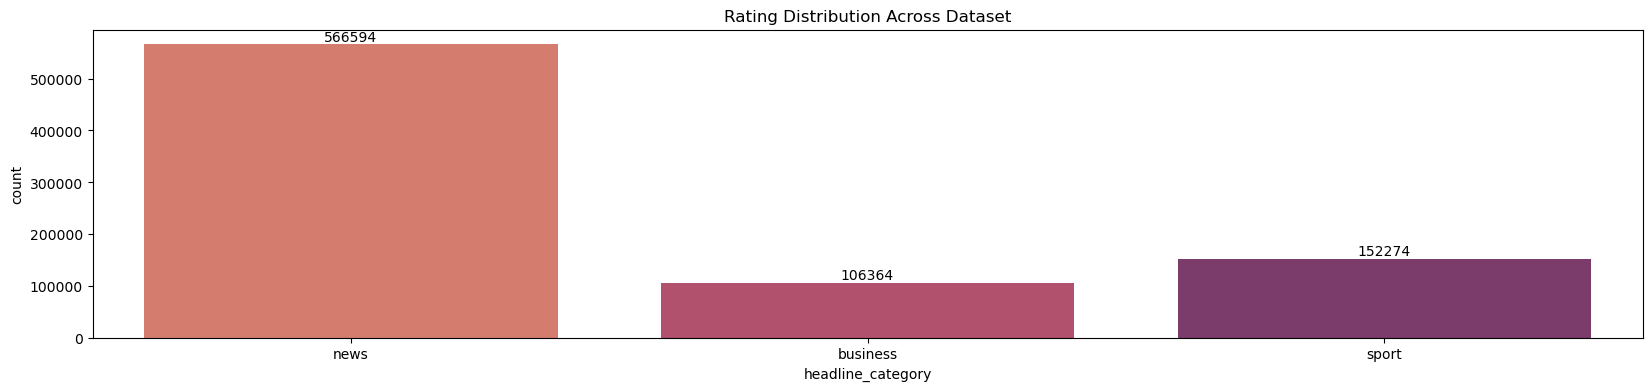

In [7]:
plt.subplots(figsize = (20,4))
ax = sns.countplot(data = data, x = 'headline_category', palette='flare')
ax.bar_label(ax.containers[0])
ax.set_title('Rating Distribution Across Dataset')

# 4. Preprocessing Text

### 4.4. Cleaning combined_text Column

In [8]:
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

def clean_text(text):
    text = text.lower()
    text = re.sub("[^a-z0-9\s]","", text)
    return text

def remove_duplicate_words(text):
    return re.sub(r'\b(\w+)(\s+\1)+\b', r'\1', text)

def lemmatizer(text):
    sentence = []
    for word in text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))
    return ''.join(sentence)

stopword_en = pd.read_csv('../../en_stopword_1555.txt', header=None).drop_duplicates()
en_stopword = stopword_en[0].values.tolist()
en_stopword = [word.strip() for word in en_stopword]

nltk_stopword = stopwords.words('english')

combined_stopwords = pd.DataFrame(en_stopword + nltk_stopword).drop_duplicates()
stopword_list = combined_stopwords[0].values.tolist()

In [9]:
data['clean_text'] = data['headline_text'] \
                    .progress_apply(clean_text) \
                    .progress_apply(lambda x: ' '.join([word for word in x.split() if word not in (nltk_stopword)])) \
                    .progress_apply(lemmatizer)
                    # .progress_apply(lambda x: ' '.join([word for word in x.split() if len(word) >= 4]))
                    # .progress_apply(remove_duplicate_words) \

data.head()

  0%|          | 0/825232 [00:00<?, ?it/s]

  0%|          | 0/825232 [00:00<?, ?it/s]

  0%|          | 0/825232 [00:00<?, ?it/s]

C:\Users\indiz\AppData\Local\Temp\ipykernel_6356\3560459141.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['clean_text'] = data['headline_text'] \


,headline_category,headline_text,clean_text
0,news,UUP sees possibility of voting Major out,uup sees possibility voting major
1,news,Pubs targeted as curbs on smoking are extended,pubs targeted curbs smoking extended
2,news,Papers reveal secret links with O'Neill cabinet,papers reveal secret links oneill cabinet
3,news,Domestic chaos as Italy takes EU presidency,domestic chaos italy takes eu presidency
4,news,Learning about the star to which we owe life,learning star owe life


In [10]:
data['clean_text'].values

array(['uup sees possibility voting major',
       'pubs targeted curbs smoking extended',
       'papers reveal secret links oneill cabinet', ...,
       'arachass 60m deal endgame fossil fuels states messy reopening',
       'england beat germany last serena williams slips wimbledon',
       'airlines failed passenger obligations pandemic outset eu auditors find'],
      dtype=object)

### 4.5. Reduce the sentence to be processed according to the desired number of words

C:\Users\indiz\AppData\Local\Temp\ipykernel_6356\2270565505.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text_len'] = pd.DataFrame(text_len)


<Axes: xlabel='text_len'>

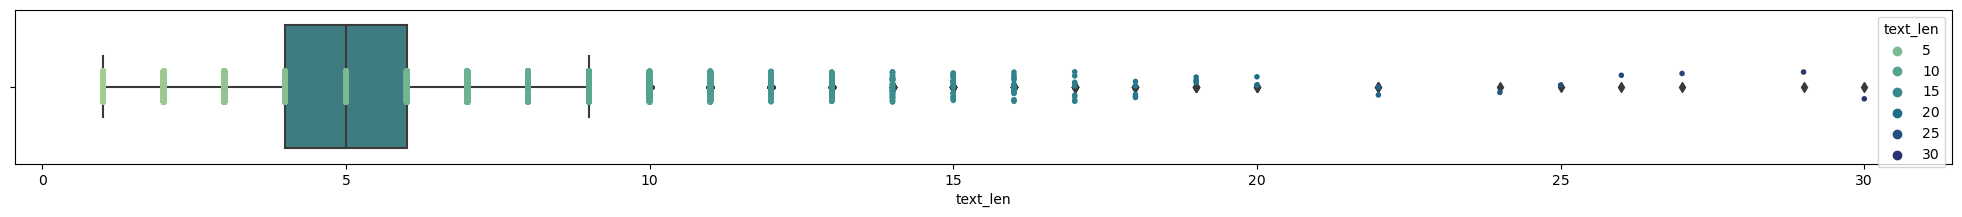

In [11]:
# text_len = []

# # for idx, teks in enumerate(data['clean_text']):
# #     text_len.append(len(teks))
# # data['text_len'] = pd.DataFrame(text_len)

text_len = [len(word) for word in data['clean_text'].str.split(' ')]
data['text_len'] = pd.DataFrame(text_len)

fig, ax = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="crest")

sns.stripplot(x=data['text_len'], data=data,
            size=4, color=".3", linewidth=0, palette="crest", hue=data['text_len'])

In [12]:
print(data['text_len'].quantile(.25))
print(data['text_len'].quantile(1.))

4.0
30.0


4.0
30.0


<Axes: xlabel='text_len'>

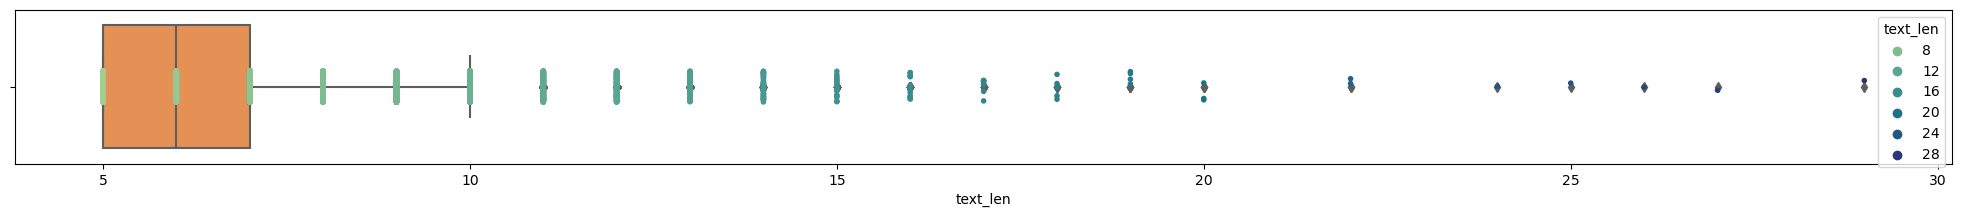

In [13]:
Q1 = data['text_len'].quantile(0.25)
Q3 = data['text_len'].quantile(1.)

print(Q1)
print(Q3)

data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="Oranges")

sns.stripplot(x=data['text_len'], data=data,
              size=4, color=".3", linewidth=0, palette="crest", hue=data['text_len'])

### 4.6. Visualize # of label after preprocessing

[Text(0, 0, '285201'), Text(0, 0, '55032'), Text(0, 0, '71146')]

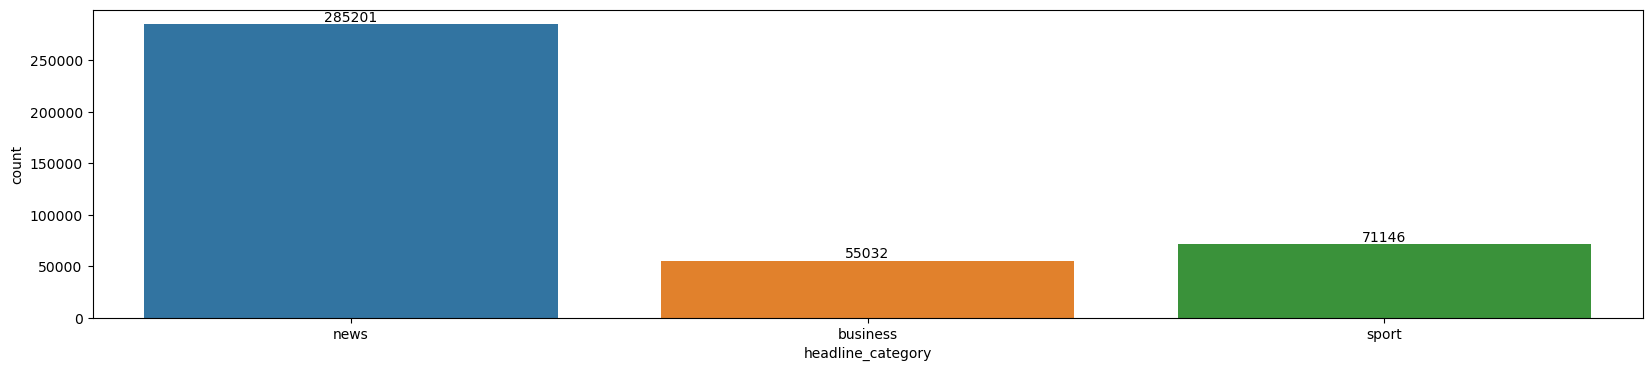

In [14]:
plt.subplots(figsize = (20,4))
ax = sns.countplot(data = data, x = 'headline_category')
ax.bar_label(ax.containers[0])

# 5. Model

### 5.1. Splitting data into Training, Testing, and Validating data

In [15]:
encoder = LabelEncoder()
category = encoder.fit_transform(data['headline_category'])

X = data['clean_text']
Y = to_categorical(category)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(288787,)
(81454,)
(41138,)


### 5.2. Declare parameter for Tokenizing and Training Model process

In [17]:
vocab_size = 30000
embedding_dim = 256
max_length = 30
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

### 5.3. Tokenizing text

In [18]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

67494


In [33]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

# Undersampling
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable

training_padded, training_label = rus.fit_resample(training_padded, training_label)
testing_padded, testing_label = rus.fit_resample(testing_padded, testing_label)
validating_padded, validating_label = rus.fit_resample(validating_padded, validating_label)

# training_label = to_categorical(training_label)
# testing_label = to_categorical(testing_label)
# validating_label = to_categorical(validating_label)

print(len(training_label))
print(len(testing_label))
print(len(validating_label))


67494
116037
32637
16422


### 5.4. Build Deep Learning Models

In [24]:
def DNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(GlobalMaxPooling1D())

    model.add(Dense(256, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    

    return model

def CNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

    model.add(Conv1D(128, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    # model.add(Dropout(0.8))
    model.add(MaxPooling1D())

    # model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    # model.add(BatchNormalization())
    # # model.add(LeakyReLU(0.2))
    # model.add(ReLU())
    # model.add(Dropout(0.5))
    # model.add(MaxPooling1D())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    # model.add(Dropout(0.5))
    model.add(MaxPooling1D())

    # model.add(Conv1D(16, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    # model.add(BatchNormalization())
    # # model.add(LeakyReLU(0.2))
    # model.add(ReLU())
    # # model.add(Dropout(0.5))
    # model.add(MaxPooling1D())

    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(32, activation='swish'))
    model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Bidirectional(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True)))
    model.add(Bidirectional(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    return model
    

# model = DNN_Model()
# model = CNN_Model()
# model = LSTM_Model()
model = GRU_Model()

model.summary()

# opt = RMSprop(learning_rate = 0.001)
# opt = SGD(learning_rate = 0.001)
opt = Adam(learning_rate = 0.00001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[tf.keras.metrics.AUC()])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 256)           7680000   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 512)          789504    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              493056    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 3)                 387       
                                                                 
Total params: 8,995,843
Trainable params: 8,995,843
No

### 5.5. Training the Model

In [25]:
num_epoch = 10
batch_size = 64

history = model.fit(training_padded, training_label, 
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (testing_padded, testing_label))

Epoch 1/10
4513/4513 [==============================] - 137s 29ms/step - loss: 0.6879 - accuracy: 0.7227 - val_loss: 0.5416 - val_accuracy: 0.7708
Epoch 2/10
4513/4513 [==============================] - 133s 29ms/step - loss: 0.4781 - accuracy: 0.7998 - val_loss: 0.4486 - val_accuracy: 0.8086
Epoch 3/10
4513/4513 [==============================] - 131s 29ms/step - loss: 0.4056 - accuracy: 0.8290 - val_loss: 0.4129 - val_accuracy: 0.8232
Epoch 4/10
4513/4513 [==============================] - 129s 29ms/step - loss: 0.3732 - accuracy: 0.8421 - val_loss: 0.4009 - val_accuracy: 0.8301
Epoch 5/10
2503/4513 [===============>..............] - ETA: 52s - loss: 0.3557 - accuracy: 0.8496

KeyboardInterrupt: 

# 6. Evaluating Performance

### 6.21. Plotting Accuracy and Loss of the Model

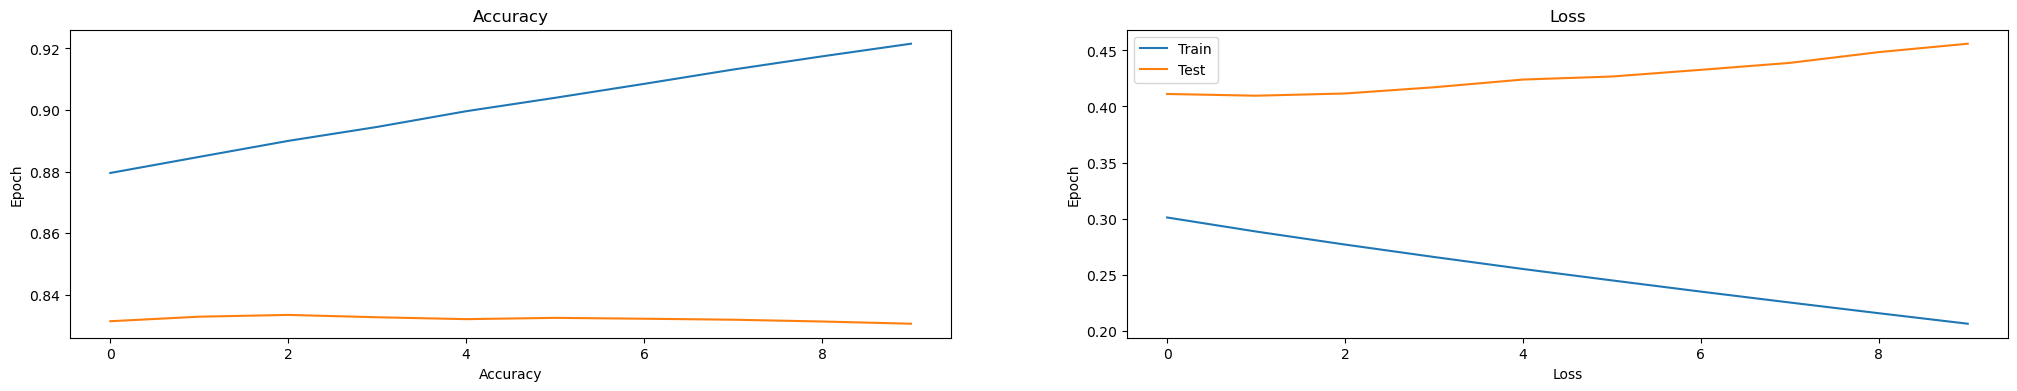

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 4))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

### 6.2. Confusion Matrix

1620/1620 [==============================] - 3s 2ms/step


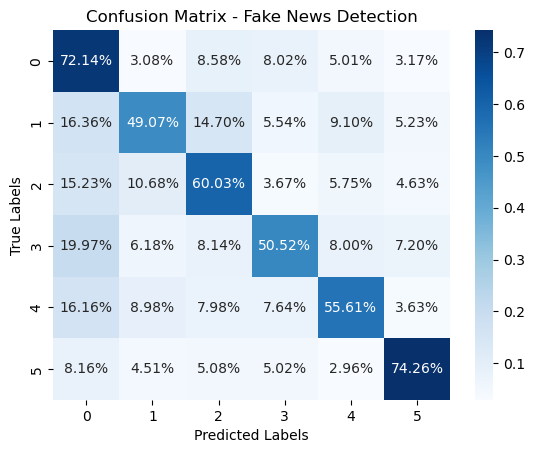

In [51]:
# labels = ['No Fraud', 'Fraud']

y_pred = np.rint(model.predict(validating_padded))
# Build confusion matrix
con_mat = confusion_matrix(validating_label.argmax(axis=1),y_pred.argmax(axis=1))

# Compute the percentages for the confusion matrix
cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

# Create the heatmap using Seaborn
# sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')

# Add labels to the plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

In [52]:
from sklearn.metrics import classification_report
y_pred = np.rint(model.predict(validating_padded))

print(classification_report(validating_label.argmax(axis=1),y_pred.argmax(axis=1)))

1620/1620 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0       0.49      0.72      0.58      8639
           1       0.59      0.49      0.54      8639
           2       0.57      0.60      0.59      8639
           3       0.63      0.51      0.56      8639
           4       0.64      0.56      0.60      8639
           5       0.76      0.74      0.75      8639

    accuracy                           0.60     51834
   macro avg       0.61      0.60      0.60     51834
weighted avg       0.61      0.60      0.60     51834



### 6.3. ROC Curve 

1620/1620 [==============================] - 3s 2ms/step


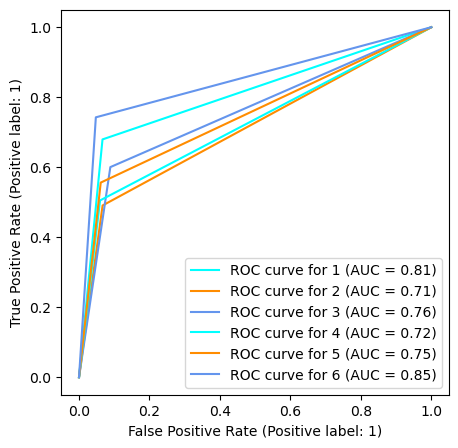

In [53]:
y_pred = np.rint(model.predict(validating_padded))
n_classes = 6

fig, ax = plt.subplots(figsize=(5, 5))
# target_names = ['1', '2', '3', '4', '5']
target_names = ['1', '2', '3', '4', '5', '6']

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        validating_label[:, class_id],
        y_pred[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )